In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

## Loading the Data

In [4]:
paps = spark.read.json("../data/processed/dummy.json/")

In [5]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())

## Clustering

In [6]:
cols = papersWIDs.columns
cols.remove("title")
cols.remove("id")
cols

['CERN_LHC_Coll',
 'GeV',
 'None',
 'background',
 'cosmological_model',
 'effective_field_theory',
 'heavy_ion__scattering',
 'higher-order__1',
 'kinematics',
 'lattice',
 'lattice_field_theory',
 'new_physics',
 'num_refs',
 'number_of_pages',
 'numerical_calculations',
 'p_p__scattering',
 'quantum_chromodynamics',
 'quantum_chromodynamics__perturbation_theory',
 'quark',
 'sensitivity',
 'stability',
 'structure',
 'thermal']

In [7]:
from pyspark.ml.feature import MinMaxScaler, StandardScaler

In [8]:
# remving nans
print(papersWIDs.count())
papersWIDs_woNA = papersWIDs.dropna()
print(papersWIDs_woNA.count())
papersWIDs_woNA_woNone = papersWIDs_woNA.filter("None == 0")
print(papersWIDs_woNA_woNone.count())

1000
966
605


In [9]:
assembler = VectorAssembler().setInputCols(cols).setOutputCol("features")
transformed_data = assembler.transform(papersWIDs_woNA_woNone)

In [10]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [11]:
scale_model  = scaler.fit(transformed_data)
scaled_data = scale_model.transform(transformed_data)

In [12]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
metric_name = 'silhouette'
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', \
                                metricName=metric_name, distanceMeasure='squaredEuclidean')
scores = dict()
for i in range(2, 50):
    kmeans_algo = KMeans(featuresCol="scaledFeatures", k=i)
    kmeans_fit = kmeans_algo.fit(scaled_data)
    kmeans_out = kmeans_fit.transform(scaled_data)
    score = evaluator.evaluate(kmeans_out)
    print(i, " ", score)
    scores[i] = score

2   0.16886880981227267
3   0.1329283450094501
4   0.14784692113706033
5   0.16549617017219037
6   0.18702517240875352
7   0.22016290919887752
8   0.2064761163223833
9   0.259572152904044
10   0.2685300579938965
11   0.3262554982056774
12   0.28699771933828844
13   0.27887996793250197
14   0.34481739223257807
15   0.34270808496273586
16   0.34208373742071124
17   0.38822714579631656
18   0.3404051329392533
19   0.3785033153216274
20   0.3511835958374712
21   0.41868766330275325
22   0.42293936127335285
23   0.39716265382092597
24   0.4001621929757655
25   0.4257464409544815
26   0.43288151989056023
27   0.4130983550498611
28   0.42308362117120185
29   0.4349913296591952
30   0.45322090587429453
31   0.4514483221877654
32   0.4542052884493603
33   0.4633842213752675
34   0.4623631128128889
35   0.454037190829175
36   0.4459860600762776
37   0.47443797227439105
38   0.4871676100925165
39   0.46314205378693146
40   0.49739895199482526
41   0.46511448068855926
42   0.4843995582213066
43   

In [13]:
import matplotlib.pyplot as plt

import numpy as np

In [14]:
scores_array = np.array([[k, scores[k]] for k in scores.keys()])

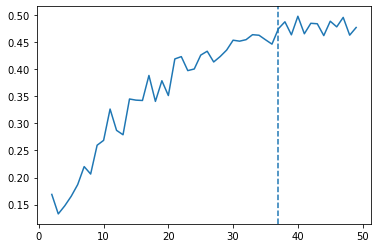

In [15]:
plt.plot(scores_array[:,0], scores_array[:,1])
plt.axvline(x=37, linestyle = '--')

## Visualization 

In [16]:
Lcost = []
for k in range(2, 50):
    model = KMeans(featuresCol="scaledFeatures", k=k, seed=1).fit(scaled_data)
    cost = model.summary.trainingCost
    print(k," ", cost)
    Lcost = Lcost + [cost]

2   12636.19475750508
3   11963.195726572154
4   11297.811516954574
5   10753.267560129389
6   10248.157169914937
7   9490.173243588806
8   9145.384075950937
9   8555.427939209874
10   8192.823774487353
11   7650.351605360311
12   7591.903974753618
13   7116.909181489746
14   6730.178750036118
15   6443.347730709377
16   6378.9467655339895
17   5860.550935719617
18   5677.20361274077
19   5789.9171038634495
20   6273.918975279349
21   5727.866874906583
22   5520.301879871151
23   5234.678875320465
24   5115.390922066325
25   5359.430766462036
26   4694.615000497095
27   4686.7548169641095
28   4373.2142119246155
29   4659.179492699393
30   4178.288381623576
31   3974.584781688009
32   4194.720149470908
33   4050.9487501361723
34   3717.1253081824643
35   3817.337056916691
36   3646.6578623617793
37   3732.2026114880323
38   3496.6571280006397
39   3422.519901928335
40   3431.946263723979
41   3575.734244153486
42   3422.2093217296947
43   3338.4901564696947
44   3395.244762881487
45   

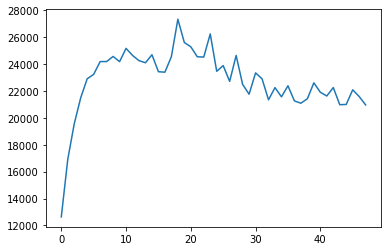

In [19]:
plt.plot( 
    np.array(Lcost)*np.sqrt(range(1,49))
)
#plt.ylim(0)

In [70]:
model.summary.trainingCost

3027.0537220926562

In [38]:
centers = model.clusterCenters()

In [40]:
cl0 = preds.filter("prediction == 0").select("features")

In [44]:
cl0.toPandas()["features"]

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


SparseVector(23, {9: 1.0, 10: 1.0, 12: 105.0, 13: 15.0})

In [48]:
rdds = cl0.select("features").rdd.map(lambda row: row.features.toAray())

In [49]:
rdds.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1389.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1389.0 (TID 1277) (41c998e018dc executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_5619/2876336510.py", line 1, in <lambda>
AttributeError: 'SparseVector' object has no attribute 'toAray'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_5619/2876336510.py", line 1, in <lambda>
AttributeError: 'SparseVector' object has no attribute 'toAray'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [29]:
preds.groupby("prediction").count().sort(desc("count"))

prediction,count
28,54
5,42
12,37
10,36
11,35
6,34
1,34
16,32
20,28
18,27


### Stability

In [188]:
def clusters_to_dict(preds = None, seed = 1, k = 37, data = scaled_data):
    """
    clusters data using KMeans alorith with specified seed and number of clusters 
    and returns result as a dictionary id:cluster
    """
    if not preds:
        preds = KMeans(featuresCol="scaledFeatures", k=k, seed=seed).\
            fit(data).\
            transform(scaled_data).select("id", "prediction")
    pred_dict = dict()
    for k_ in range(k):
        cl_dict = {p[0]:k_ for p in preds.filter("prediction == "+str(k_)).select("id").collect()}
        pred_dict = pred_dict | cl_dict
    return pred_dict

In [205]:
def cluster_conjugation_matrix(cluster_dict, n = None):
    """
    returns conjugations matrix from the clustr dict
    """
    if not n:
       n=len( cluster_dict.keys())
    keys = cluster_dict.keys()
    return np.array(
        [[1 if cluster_dict[i1] == cluster_dict[i2] else 0 for i1 in keys] for i2 in keys]
    )

In [230]:
R1 = clusters_to_dict(seed = 4, k=100)
R2 = clusters_to_dict(seed = 10, k=100)

M1 = cluster_conjugation_matrix(R1)
M2 = cluster_conjugation_matrix(R2)

np.sum(np.abs(M1 - M2))/M1.size

0.09436300229979626